In [128]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import functools
import seaborn as sn

In [129]:
df_tweets = pd.read_csv('data/tweets_no_dupl.csv', sep='#')
df_users = pd.read_csv('data/users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

## user_id
In the user_id column there are a lot of missing values, wrong values (non-numerical ids) and 210778 user ids do not have any correspondence with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.

## retweet_count


In [130]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              11712346 non-null  object
 1   user_id         11495314 non-null  object
 2   retweet_count   11275326 non-null  object
 3   reply_count     11064671 non-null  object
 4   favorite_count  11064981 non-null  object
 5   num_hashtags    10655073 non-null  object
 6   num_urls        11063920 non-null  object
 7   num_mentions    10858432 non-null  object
 8   created_at      11712348 non-null  object
 9   text            11182415 non-null  object
dtypes: object(10)
memory usage: 893.6+ MB


In [131]:
df_tweets.drop(columns=['id'], inplace=True)

Select records which have both user_id and text values which are null

In [132]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56118 entries, 42 to 11712030
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         0 non-null      object
 1   retweet_count   51567 non-null  object
 2   reply_count     25737 non-null  object
 3   favorite_count  50960 non-null  object
 4   num_hashtags    392 non-null    object
 5   num_urls        26107 non-null  object
 6   num_mentions    466 non-null    object
 7   created_at      56118 non-null  object
 8   text            0 non-null      object
dtypes: object(9)
memory usage: 4.3+ MB


Merge users table with tweets table by user_id

In [133]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')


In [134]:
df_tweets.shape

(11712348, 9)

In [135]:
merged.shape

(11712348, 16)

Number of `user_id` that have no correspondance in users file.

In [136]:
len(merged[merged['id'].isnull()].user_id.unique())

210778

Cast column values to float (there are number to big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [137]:
def to_float(x):
    try:
        x=float(x)
        if(np.isnan(x)):
            return float(-1)
        else:
            return x
    except:
        return float(-1)

# Correlation tests

In [138]:
def eval_correlation(df_corr, method='pearson'):
    correlation_matrix = df_corr.corr(method=method)
    sn.heatmap(correlation_matrix, annot=True)
    plt.show()

In [139]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [140]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [141]:
df_tweets['favorite_count_conv'] = df_tweets.favorite_count.apply(to_float)

We have noticed a lot of huge values in the `retweet_count_conv` **(RCC)** column. By analysing statistics of real tweets on the web, we have decide to perform further analysis on records having a RCC value lower than 1e7 (https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets)

In [142]:
threshold = 1e7
df_correlation = pd.DataFrame()
df_correlation = df_tweets[functools.reduce(np.logical_and,
                                (np.logical_and(df_tweets['retweet_count_conv'] != -1, df_tweets['retweet_count_conv'] < threshold),
                                np.logical_and(df_tweets['reply_count_conv'] != -1, df_tweets['reply_count_conv'] < threshold),
                                np.logical_and(df_tweets['favorite_count_conv'] != -1, df_tweets['favorite_count_conv'] < threshold)))
                    ][['retweet_count_conv', 'reply_count_conv', 'favorite_count_conv']]
df_correlation.head()

,retweet_count_conv,reply_count_conv,favorite_count_conv
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,114.0,0.0,0.0


In [143]:
df_correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10297438 entries, 0 to 11712347
Data columns (total 3 columns):
 #   Column               Dtype  
---  ------               -----  
 0   retweet_count_conv   float64
 1   reply_count_conv     float64
 2   favorite_count_conv  float64
dtypes: float64(3)
memory usage: 314.3 MB


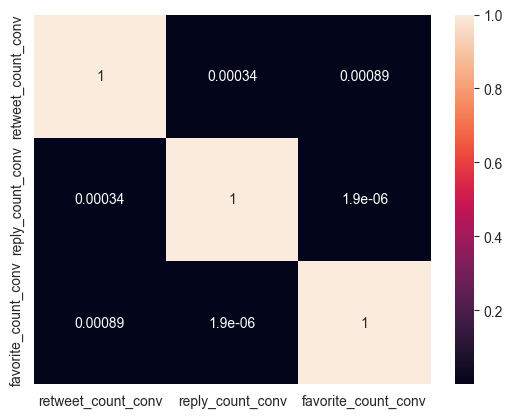

In [144]:
eval_correlation(df_correlation)

C:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4868: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


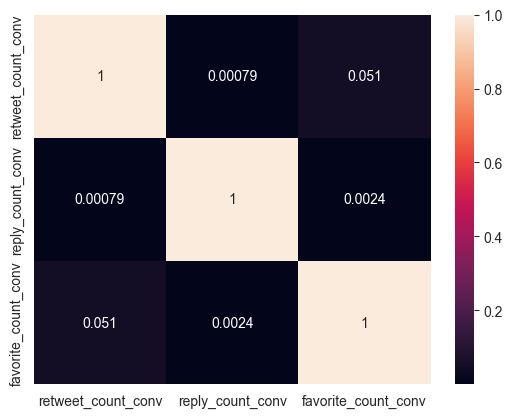

In [145]:
eval_correlation(df_correlation, 'kendall')

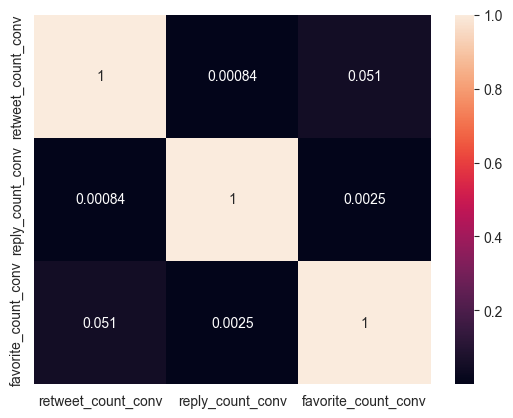

In [146]:
eval_correlation(df_correlation, 'spearman')

## Clean retweet_counts column

Plot a histogram w.r.t. a single attribute passed as parameter.

In [147]:
def plot_hist(dataframe, attribute_name, log=False):
    df = pd.DataFrame()

    if log:
        log_attribute_name = attribute_name+'_log'
        df[log_attribute_name] = np.log(dataframe[attribute_name].values)

        attribute_name = log_attribute_name
        df[attribute_name] = df[attribute_name].replace(-np.inf, 0)

    else:
        df[attribute_name] = dataframe[attribute_name].values
    n_bins = math.ceil(np.log2(len(df[attribute_name])) + 1) #Sturges' rule
    df.hist(attribute_name, bins = n_bins, log=True)

In [148]:
def fix_missing_values(df, col):
    #Extract statistical indicators from the indicated column
    mean = np.mean(df[col].values)
    median = np.median(df[col].values)
    print("mean: " + str(mean))
    print("median: " + str(median))

    #Plot the distribution of the indicated column
    plt.boxplot(df_tweets[df[col] != -1.0][col],showmeans=True)
    plt.yscale('log')
    plt.show()

    #Substitute all the -1.0 values (missing values) with the median
    df[col+'_rep'] = df[col].replace({-1.0: median})

    return df

In [149]:
def replace_with_user_median(df, attribute_name, users_to_replace):
    to_replace = df['user_id'].isin(users_to_replace)
    attribute_median = df[~to_replace][attribute_name].median()

    df_replaced = df[to_replace]
    def publication_median_for_user(user_id):

        if pd.isnull(user_id):
            return attribute_median
        else:
            return df_replaced[df_replaced['user_id'] == user_id][attribute_name].median()


    median_dict= {}
    for user_id in users_to_replace:
        median_dict[user_id] = publication_median_for_user(user_id)

    def replace_median(row):
        try:
            return median_dict[row.user_id]
        except KeyError:
            return row[attribute_name]

    df_replaced[attribute_name] = df_replaced.apply(replace_median, axis=1)

    df.loc[df_replaced.index, attribute_name] = df_replaced[attribute_name]

    return df

In [175]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   retweet_count        object        
 2   reply_count          object        
 3   favorite_count       object        
 4   num_hashtags         object        
 5   num_urls             object        
 6   num_mentions         object        
 7   created_at           datetime64[ns]
 8   text                 object        
 9   retweet_count_conv   float64       
 10  reply_count_conv     float64       
 11  favorite_count_conv  float64       
 12  created_at_conv      int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 1.1+ GB


As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.

In [176]:
#df_tweets.loc[tweets_before_foundation.index, 'created_at_conv'] = tweets_before_foundation.created_at_conv
ids_list = df_tweets[df_tweets['retweet_count_conv'] == -1.0].user_id
df_tweets = replace_with_user_median(df_tweets, 'retweet_count_conv', ids_list)


KeyboardInterrupt: 

In [ ]:
df_tweets[df_tweets['retweet_count_conv'] == -1.0]

In [102]:
df_tweets.drop(columns = ['retweet_count_conv', 'retweet_count'], inplace=True)

Now we have `retweet_count_replaced` with all numeric values. We have many values that seems to be "noise" but before replacing them we want to explore the correlation with other attributes related to the tweet popularity which are  `reply_count` and `favourite_count`. So this task is postponed. Instead for the missing values (-1) we have checked if the same user has other tweets in the dataset to extract statistics from them. If there are not other tweets or there are only tweets with missing values the median is set as default.

# Clean reply_count column

mean: inf
median: 0.0


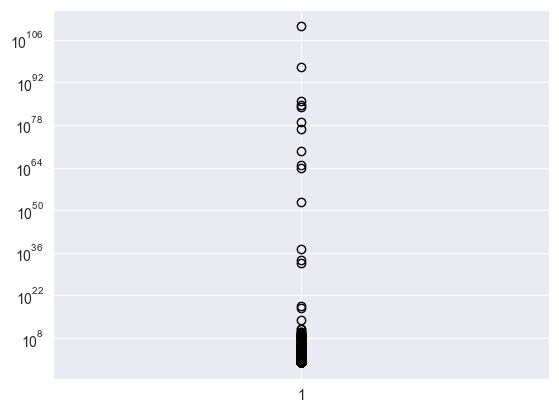

In [103]:
df_tweets = fix_missing_values(df_tweets, 'reply_count_conv')

In [104]:
df_tweets.drop(columns = ['reply_count_conv', 'reply_count'], inplace=True)

# Clean favourite_counts column

mean: inf
median: 0.0


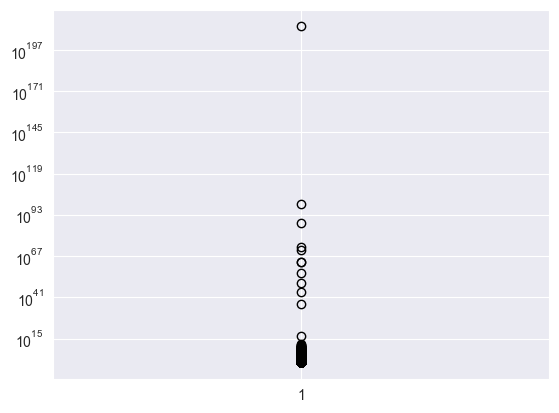

In [105]:
df_tweets = fix_missing_values(df_tweets, 'favorite_count_conv')

In [28]:
df_tweets.drop(columns = ['favorite_count_conv', 'favorite_count'], inplace=True)

# Number of hashtags

In [29]:
df_tweets['num_hashtags_conv'] = df_tweets.num_hashtags.apply(to_float)

mean: inf
median: 0.0


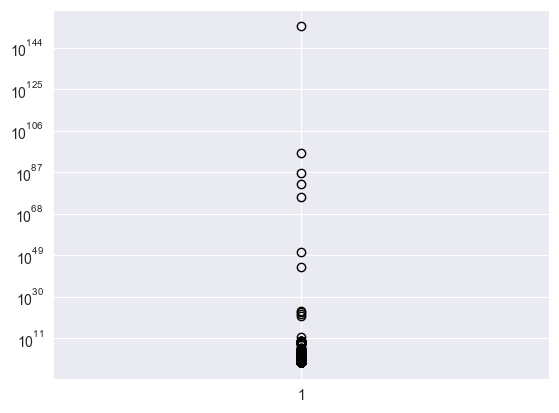

In [30]:
df_tweets = fix_missing_values(df_tweets, 'num_hashtags_conv')

In [31]:
df_tweets.drop(columns = ['num_hashtags_conv', 'num_hashtags'], inplace=True)

# Number of urls

In [32]:
df_tweets['num_urls_conv'] = df_tweets.num_urls.apply(to_float)

mean: inf
median: 0.0


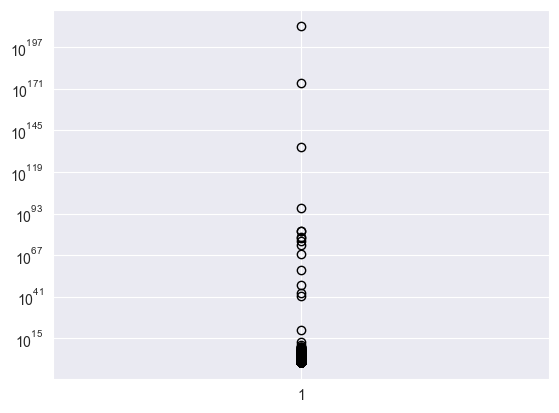

In [33]:
df_tweets = fix_missing_values(df_tweets, 'num_urls_conv')

In [34]:
df_tweets.drop(columns = ['num_urls_conv', 'num_urls'], inplace=True)

# Number of mentions

In [35]:
df_tweets['num_mentions_conv'] = df_tweets.num_mentions.apply(to_float)

mean: inf
median: 0.0


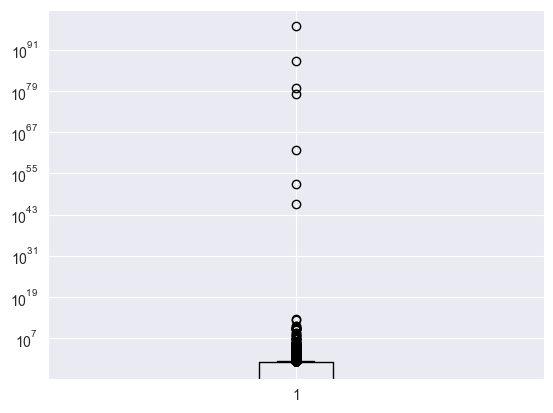

In [36]:
df_tweets = fix_missing_values(df_tweets, 'num_mentions_conv')

In [37]:
df_tweets.drop(columns = ['num_mentions_conv', 'num_mentions'], inplace=True)

# Created at

<AxesSubplot:>

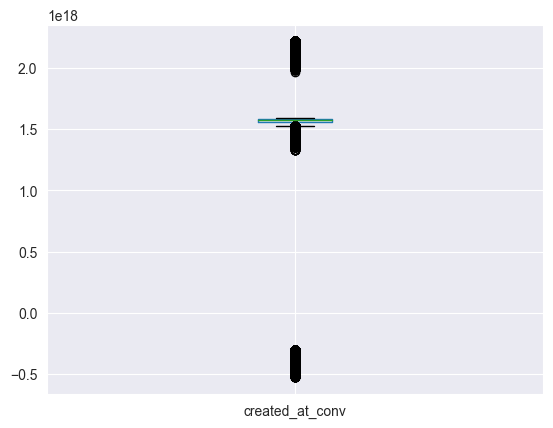

In [151]:
df_tweets['created_at_conv'] = pd.to_datetime(df_tweets['created_at']).astype(np.int64)
df_tweets.boxplot(['created_at_conv'])

Since Twitter was founded in 2006, the values in `created_at` that are antecedent to that year are considered wrong

In [152]:
twitter_foundation = pd.to_datetime(["20060321"]).astype(np.int64)[0]
twitter_foundation

1142899200000000000

## Substitution of tweets before tweeter foundation
We will proceed substituting the wrong value with the median of the activity of each user. For the tweets for which we do not have the `user_id` value, we replace it with the median of the whole dataset.

In [153]:
tweets_before_foundation = df_tweets[df_tweets['created_at_conv'] < twitter_foundation]

In [154]:
tweets_after_foundation = df_tweets[df_tweets['created_at_conv'] > twitter_foundation]

In [155]:
tbf_users = tweets_before_foundation.user_id.unique()
tbf_users

array(['14824425', '14626600', '1852825657', '1860371966', '14905688',
       '493739792', '491630583', '1730251326', '1770131138', '498418001',
       '158038746', '157158598', '495020496', '508397359', '157029836',
       '496673471', '1877304734', '490712110', '164284493', '1853487314',
       '14443013', '164940888', '508355849', '14300066', '14307043',
       '161634919', '1862854957', '1716457568', '164983683', '1886647662',
       '160139625', '1727495887', '14716324', '14522589', '503771485',
       '157959714', '491673056', '1855455756', '14247395', '157900625',
       '161662393', '499737312', '14764956', '156751025', '1724424804',
       '157683018', '1871678053', '13381912', '494687529', '162018954',
       '14587971', '503262878', '1858934186', '14196068', '163523407',
       '14265485', '1733095801', '1736045779', '505959713', '157809852',
       '159209237', '497404180', '164380206', '497557514', '491706663',
       '497521332', '159691975', '496168830', '14391111', '165

In [156]:
tweets_publication_median = tweets_after_foundation.created_at_conv.median()
def publication_median_for_user(user_id):
    if pd.isnull(user_id):
        return tweets_publication_median
    else:
        return tweets_after_foundation[tweets_after_foundation['user_id'] == user_id].created_at_conv.median()

median_dict= {}
for user_id in tbf_users:
    median_dict[user_id] = publication_median_for_user(user_id)

In [157]:
def replace_median(row):
    return median_dict[row.user_id]

tweets_before_foundation['created_at_conv'] = tweets_before_foundation.apply(replace_median, axis=1)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25864\1364923207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_before_foundation['created_at_conv'] = tweets_before_foundation.apply(replace_median, axis=1)


<AxesSubplot:>

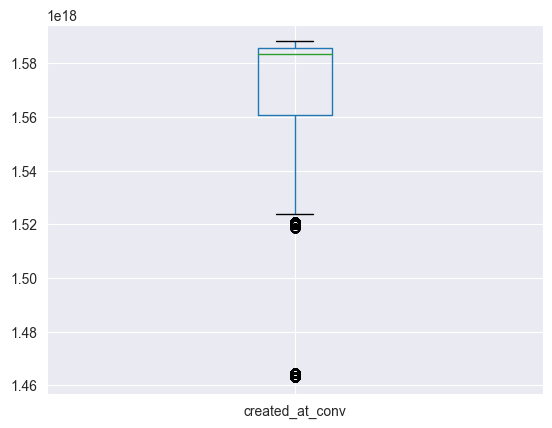

In [158]:
tweets_before_foundation.boxplot(['created_at_conv'])

In [159]:
tweets_before_foundation

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,created_at_conv
223,14824425,0,0,0,1,0,1,1960-04-26 18:05:56,@arvixesupport Shared SSL stopped working on a...,0.0,0.0,0.0,1.558459e+18
421,14626600,0,0,0,0,0,1,1958-03-15 16:54:57,@nancyjensen Harry &amp; dwntwn 95% clear of s...,0.0,0.0,0.0,1.523797e+18
959,1852825657,0,0,0,1,0,0,1959-05-02 23:16:40,Her tl is sooo dead omgg #herbff,0.0,0.0,0.0,1.580355e+18
1070,1860371966,0,0,1,0,0,1,1960-01-29 07:16:43,@_Stellajess,0.0,0.0,1.0,1.582582e+18
1483,14905688,0,0,0,0,0,0,1960-04-14 15:10:36,Dreaming about freshly brewed cider. Just a ma...,0.0,0.0,0.0,1.583335e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11711586,1871678053,0,0,0,0,0,0,1960-03-28 14:04:52,Grabe naman yung culture nila,0.0,0.0,0.0,1.583399e+18
11711771,1719992982,26,0,0,0,0,1,1960-05-12 17:31:43,RT @ACrowen: I can't stop thinking about Ameli...,26.0,0.0,0.0,1.587078e+18
11711960,505433014,0,0,0,0,0,0,1960-03-17 01:36:18,I hate when people eat and they talk. Then the...,0.0,0.0,0.0,1.584083e+18
11712112,1858934186,1730,0,0,0,0,1,1960-03-18 12:53:14,RT @chiIIout: i want to do so much more in thi...,1730.0,0.0,0.0,1.583449e+18


In [160]:
#df_tweets.loc[tweets_before_foundation.index, 'created_at_conv'] = tweets_before_foundation.created_at_conv
df_tweets = replace_with_user_median(df_tweets, 'created_at_conv', tweets_before_foundation.user_id)


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25864\1270145059.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_replaced[attribute_name] = df_replaced.apply(replace_median, axis=1)


,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,created_at_conv
0,327746321,0,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang...",0.0,0.0,0.0,1568213635000000000
1,333722906,1,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit...",1.0,0.0,0.0,1585772824000000000
2,2379755827,0,0,0,0,0,1,2019-05-02 13:34:31,@LOLatComedy awsome,0.0,0.0,0.0,1556804071000000000
3,466226882,0,0,0,0,0,0,2019-11-04 07:17:37,Stephen Hawkins: i buchi neri non esistono se ...,0.0,0.0,0.0,1572851857000000000
4,1355537995,114,0,0,1,0,1,2020-03-11 16:45:31,RT @tibbs_montris: So ready for Wednesday!,114.0,0.0,0.0,1583945131000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11712343,220933018,0,0,0,0,0,0,2018-05-04 05:29:33,ESTA MANANA AUN ESTA MUY FRIO ! MIREN ESTO ! ...,0.0,0.0,0.0,1525411773000000000
11712344,587491046,0,0,0,0,0,1,2020-04-17 02:51:53,"@warriors Congrats, maybe I'll be able to get ...",0.0,0.0,0.0,1587091913000000000
11712345,91781300,0,NaN,l25suv5,NaN,0.0,NaN,2016-07-10 22:43:09,NaN,0.0,-1.0,-1.0,1468190589000000000
11712346,127895572,0,0,1,1,0,0,2019-03-07 19:56:55,Shooting crew of porn movies. #TheWorstJobToHave,0.0,0.0,1.0,1551988615000000000


In [163]:
pd.to_datetime(df_tweets_rpl_created_at['created_at_conv'])

0          2019-09-11 14:53:55
1          2020-04-01 20:27:04
2          2019-05-02 13:34:31
3          2019-11-04 07:17:37
4          2020-03-11 16:45:31
                   ...        
11712343   2018-05-04 05:29:33
11712344   2020-04-17 02:51:53
11712345   2016-07-10 22:43:09
11712346   2019-03-07 19:56:55
11712347   2019-07-10 12:00:00
Name: created_at_conv, Length: 11712348, dtype: datetime64[ns]

In [164]:
df_tweets.created_at = pd.to_datetime(df_tweets_rpl_created_at['created_at_conv'])

In [171]:
df_tweets.created_at_conv = df_tweets_rpl_created_at['created_at_conv']

In [168]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 13 columns):
 #   Column               Non-Null Count     Dtype         
---  ------               --------------     -----         
 0   user_id              11495314 non-null  object        
 1   retweet_count        11275326 non-null  object        
 2   reply_count          11064671 non-null  object        
 3   favorite_count       11064981 non-null  object        
 4   num_hashtags         10655073 non-null  object        
 5   num_urls             11063920 non-null  object        
 6   num_mentions         10858432 non-null  object        
 7   created_at           11712348 non-null  datetime64[ns]
 8   text                 11182415 non-null  object        
 9   retweet_count_conv   11712348 non-null  float64       
 10  reply_count_conv     11712348 non-null  float64       
 11  favorite_count_conv  11712348 non-null  float64       
 12  created_at_conv      11712348 non-null  

<AxesSubplot:>

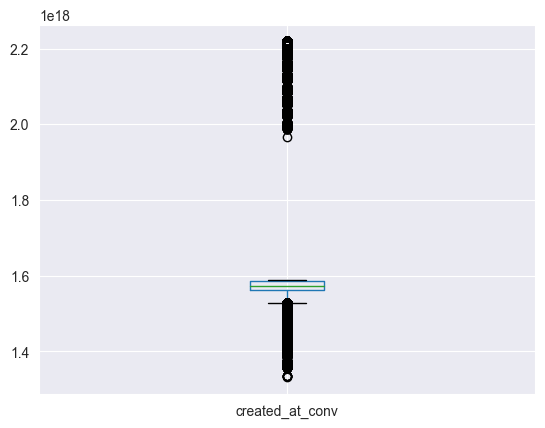

In [172]:
df_tweets.boxplot('created_at_conv')

From the boxplot it seems that we have a mixture of 2 gaussians, so we zoom in into these two.

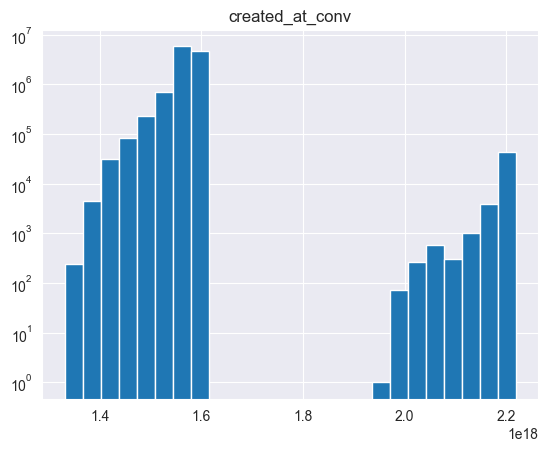

In [173]:
plot_hist(df_tweets, 'created_at_conv')

<AxesSubplot:>

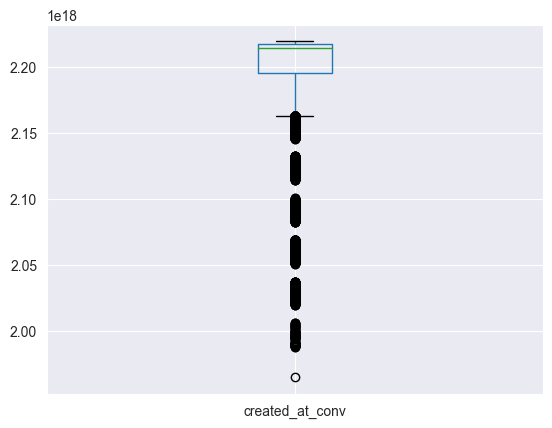

In [174]:
df_tweets[df_tweets['created_at_conv'] > 1.8e18].boxplot(['created_at_conv'])

<AxesSubplot:>

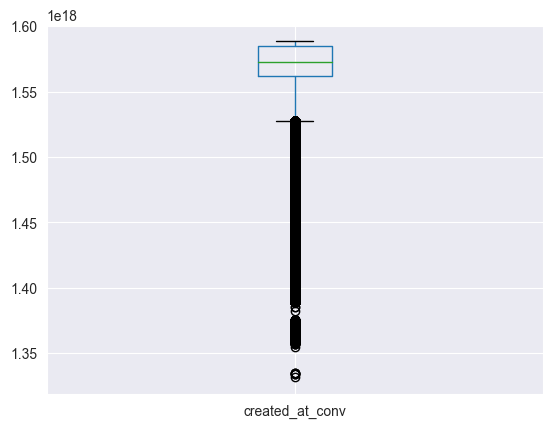

In [61]:
df_tweets[df_tweets['created_at_conv'] < 1.8e18].boxplot(['created_at_conv'])

In [53]:
df_tweets[df_tweets['retweet_count_replaced'] < 1e6].boxplot('retweet_count_replaced', showmeans=True)

KeyError: 'retweet_count_replaced'

In [ ]:
droppe = df_tweets[np.logical_and(df_tweets['retweet_count_conv'] != -1.0, df_tweets['retweet_count_conv'] < threshold)]

In [ ]:
plt.boxplot(droppe.retweet_count_conv,showmeans=True)
plt.yscale('log')
plt.show()

The boxplot is not informative, so we investigate this field by means of an histogram.

In [ ]:
plot_hist(droppe, 'retweet_count_conv', log=True)

In [ ]:
merged = df_tweets[df_tweets['retweet_count_replaced'] > 1e10].merge(df_users, left_on='user_id', right_on='id', how='left')
merged[['user_id', 'retweet_count_replaced', 'reply_count', 'favorite_count', 'bot', 'created_at_x', 'created_at_y', 'text', 'statuses_count']]

In [ ]:
plot_hist(df_tweets[df_tweets['reply_count_conv'] < 1e10], 'reply_count_conv')